<a href="https://colab.research.google.com/github/anustupdas/document-sucject-classification/blob/main/Final_Training_data_Exploration_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This Notebook will enable you to play with the Training data and have a good idea about the distribution of the data.


**Here we by defauilt connect to the preprocessed data So that we can demonstate the changes in the data distribution after preprocessing the Raw data.**

In [2]:
%%capture
!pip install transformers
!pip install torch

In [3]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd
import json
import gc

from sklearn.model_selection import train_test_split

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopw = stopwords.words('english')
nltk.download('punkt')

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot

from tqdm import tqdm
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
!unzip training_data_output_no_break.zip

## Util Functions

In [4]:
def get_df_from_dict(meta_dict):
  metadata_df_list = []
  mt_du = meta_dict

  for key in mt_du.keys():
    file_count = len(mt_du[key])
    max_word_count = max(mt_du[key])
    min_word_count = min(mt_du[key])
    avg_word_count = np.mean(mt_du[key])
    files_below_10_words = sum(i < 10 for i in mt_du[key])
    files_below_512_words = sum(i < 512 for i in mt_du[key])
    files_above_1000_words = sum(i > 1000 for i in mt_du[key])
    files_above_3000_words = sum(i > 3000 for i in mt_du[key])
    k = (key , file_count,max_word_count,min_word_count,int(avg_word_count),files_below_10_words,files_below_512_words,files_above_1000_words,files_above_3000_words)
    metadata_df_list.append(k)

  metadata_df = pd.DataFrame(metadata_df_list, columns=['Category','file_count','max_word_count', 'min_word_count','avg_word_count','files_below_10_words','files_below_512_words','files_above_1000_words','files_above_3000_words'])
  return metadata_df

def get_metadata_from_df(data_frame):

  metadata_dict = {}
  for index, row in data_frame.iterrows():
    #print(row['category'], row['count'])
    if row['category'] not in metadata_dict.keys():
      metadata_dict[row['category']] = []
    metadata_dict[row['category']].append(row['count'])



  return get_df_from_dict(metadata_dict)


In [5]:
def plot_bar_chart(metadata_df, key_to_sort, small_first= False):

  metadata_df = metadata_df.sort_values(key_to_sort, ascending=small_first)
  category_count = metadata_df['Category'].value_counts()

  categories = category_count.index

  fig = plt.figure(figsize= (120, 50))

  ax = fig.add_subplot(111)

  sns.barplot(x = categories, y = metadata_df[key_to_sort] )

  for a, p in enumerate(ax.patches):
      ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )

  plt.xlabel('Categories', size = 15)

  plt.ylabel('The Number of News', size= 15)

  plt.xticks(size = 12)

  plt.title("The number of News by Categories" , size = 18)

  plt.show()


## Starting Point

In [7]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [8]:

df_train = pd.read_csv("/content/drive/MyDrive/medior-data-scientist-case-study/training_data_all_clean_chucked/train/clean_subject_classification_Train.csv")
df_dev = pd.read_csv("/content/drive/MyDrive/medior-data-scientist-case-study/training_data_all_clean_chucked/dev/clean_subject_classification_Val.csv")
df_test = pd.read_csv("/content/drive/MyDrive/medior-data-scientist-case-study/training_data_all_clean_chucked/test/clean_subject_classification_Test.csv")


df_train

,Unnamed: 0,file_name,text,summary,category
0,0,36000841.txt,surname 1 name name course date the necklace ...,surname name name course date the necklace gu...,English
1,1,12360816.txt,language functions and forms: a brief summary ...,language functions and forms: brief summary la...,English
2,2,20230408_0.txt,answered page 2 reader response tragedy make ...,answered on page reader response on tragedy ma...,English
3,3,20230408_1.txt,when jocasta found out the truth about her hus...,answered on page reader response on tragedy ma...,English
4,4,39546400_0.txt,1 writing media name institutional affiliatio...,writing for media name institutional affiliati...,English
...,...,...,...,...,...
15350,15350,49042498_3.txt,effectiveness of community policing the saps p...,school of applied human sciences assignment co...,Criminology
15351,15351,46954683_0.txt,crime name greatest dangers come acts labeled...,crime any other name some of the greatest dan...,Criminology
15352,15352,46954683_1.txt,label used to name all actions that cause crim...,crime any other name some of the greatest dan...,Criminology
15353,15353,46954683_2.txt,there is gradation of charges for cases like t...,crime any other name some of the greatest dan...,Criminology


# Histogram of the count of text

<Axes: xlabel='category'>

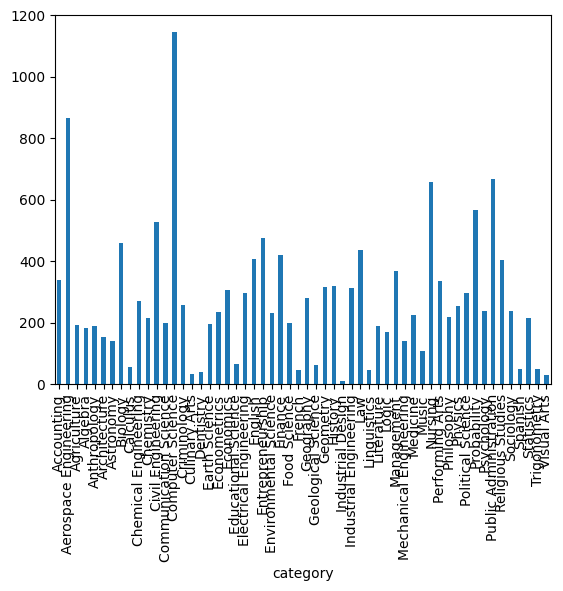

In [9]:
df_train.groupby(['category']).size().plot.bar()

In [22]:
df_train['count'] = df_train['text'].apply(lambda x: len(nltk.word_tokenize(str(x))))
df_train['summary_count'] = df_train['summary'].apply(lambda x: len(str(x).split()))

**Text file which had more than 550 words are boken into subtext file in order to capture the entire essence of the Subject topic file.**


In [28]:
df_train[107:117]

,Unnamed: 0,file_name,text,summary,category,count,summary_count
107,107,18395619_35.txt,1. contemporary adj belonging to the present t...,"буренко англійська мова рік навчання, рівень с...",English,345,26
108,108,18395619_36.txt,it is located in historic architectural comple...,"буренко англійська мова рік навчання, рівень с...",English,312,26
109,109,18395619_37.txt,serhii paradzhanov.artist filmmaker profession...,"буренко англійська мова рік навчання, рівень с...",English,272,26
110,110,18395619_38.txt,"as a student, valentyna at first visited the s...","буренко англійська мова рік навчання, рівень с...",English,314,26
111,111,18395619_39.txt,adverbs make adjectives stronger or weaker.adv...,"буренко англійська мова рік навчання, рівень с...",English,305,26
112,112,18395619_40.txt,"drink tea, not coffee, never eat toffy.eat bre...","буренко англійська мова рік навчання, рівень с...",English,284,26
113,113,18395619_41.txt,have their entire love and attention have a lo...,"буренко англійська мова рік навчання, рівень с...",English,353,26
114,114,18395619_42.txt,discuss the stresses in your lives.present ide...,"буренко англійська мова рік навчання, рівень с...",English,286,26
115,115,18395619_43.txt,suggested answer (danylo ulianitskyi) to begin...,"буренко англійська мова рік навчання, рівень с...",English,297,26
116,116,18395619_44.txt,"7. listen, read the words and their definition...","буренко англійська мова рік навчання, рівень с...",English,322,26


<Figure size 800x800 with 0 Axes>

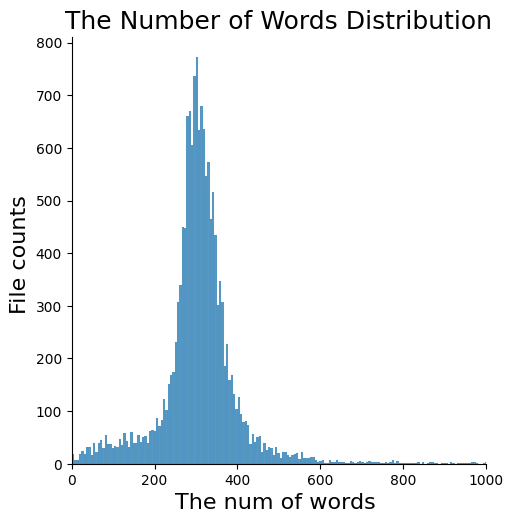

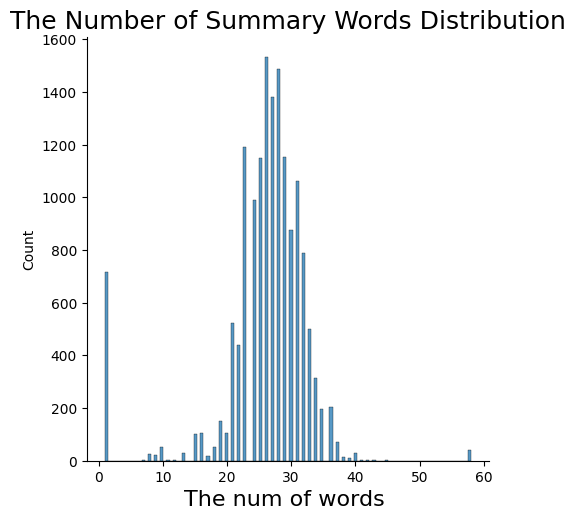

In [19]:
plt.figure(figsize= (8, 8))


sns.displot(df_train['count'])
plt.xlim(0, 1000)
plt.xlabel('The num of words ', fontsize = 16)
plt.ylabel('File counts ', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
sns.displot(df_train['summary_count'])
plt.xlabel('The num of words ', fontsize = 16)
plt.title("The Number of Summary Words Distribution", fontsize = 18)
plt.show()


**A word count distribution plot for a whole corpus is a graphical representation of the frequency of words in
the corpus, arranged according to the number of times they appear in the corpus. In this plot, the x-axis represents
 the number of times a word appears in the corpus, while the y-axis represents the number of words that appear that many times.
The plot can be used to identify the most common words in the corpus and determine the overall shape and characteristics of the corpus. It can also be compared to similar plots for other corpora to identify patterns and trends in language use.**

# Bar plot for each of the new category

In [27]:
metadata_df = get_metadata_from_df(df_train)
metadata_df

,Category,file_count,max_word_count,min_word_count,avg_word_count,files_below_10_words,files_below_512_words,files_above_1000_words,files_above_3000_words
0,English,407,781,20,296,0,401,0,0
1,Dentistry,41,1187,41,339,0,38,1,0
2,Sociology,237,565,15,272,0,235,0,0
3,Accounting,339,939,15,339,0,333,0,0
4,French,45,572,1,284,4,44,0,0
5,Law,436,706,18,293,0,430,0,0
6,Industrial Design,9,1112,35,360,0,7,1,0
7,Geological Science,64,576,18,309,0,56,0,0
8,Aerospace Engineering,867,1159,19,306,0,856,1,0
9,Communication Science,198,1482,22,287,0,192,3,0


Example Usage:



```
# plot_bar_chart(meta-data-frame, 'column-name-to-sort-for', small_first = False)
```



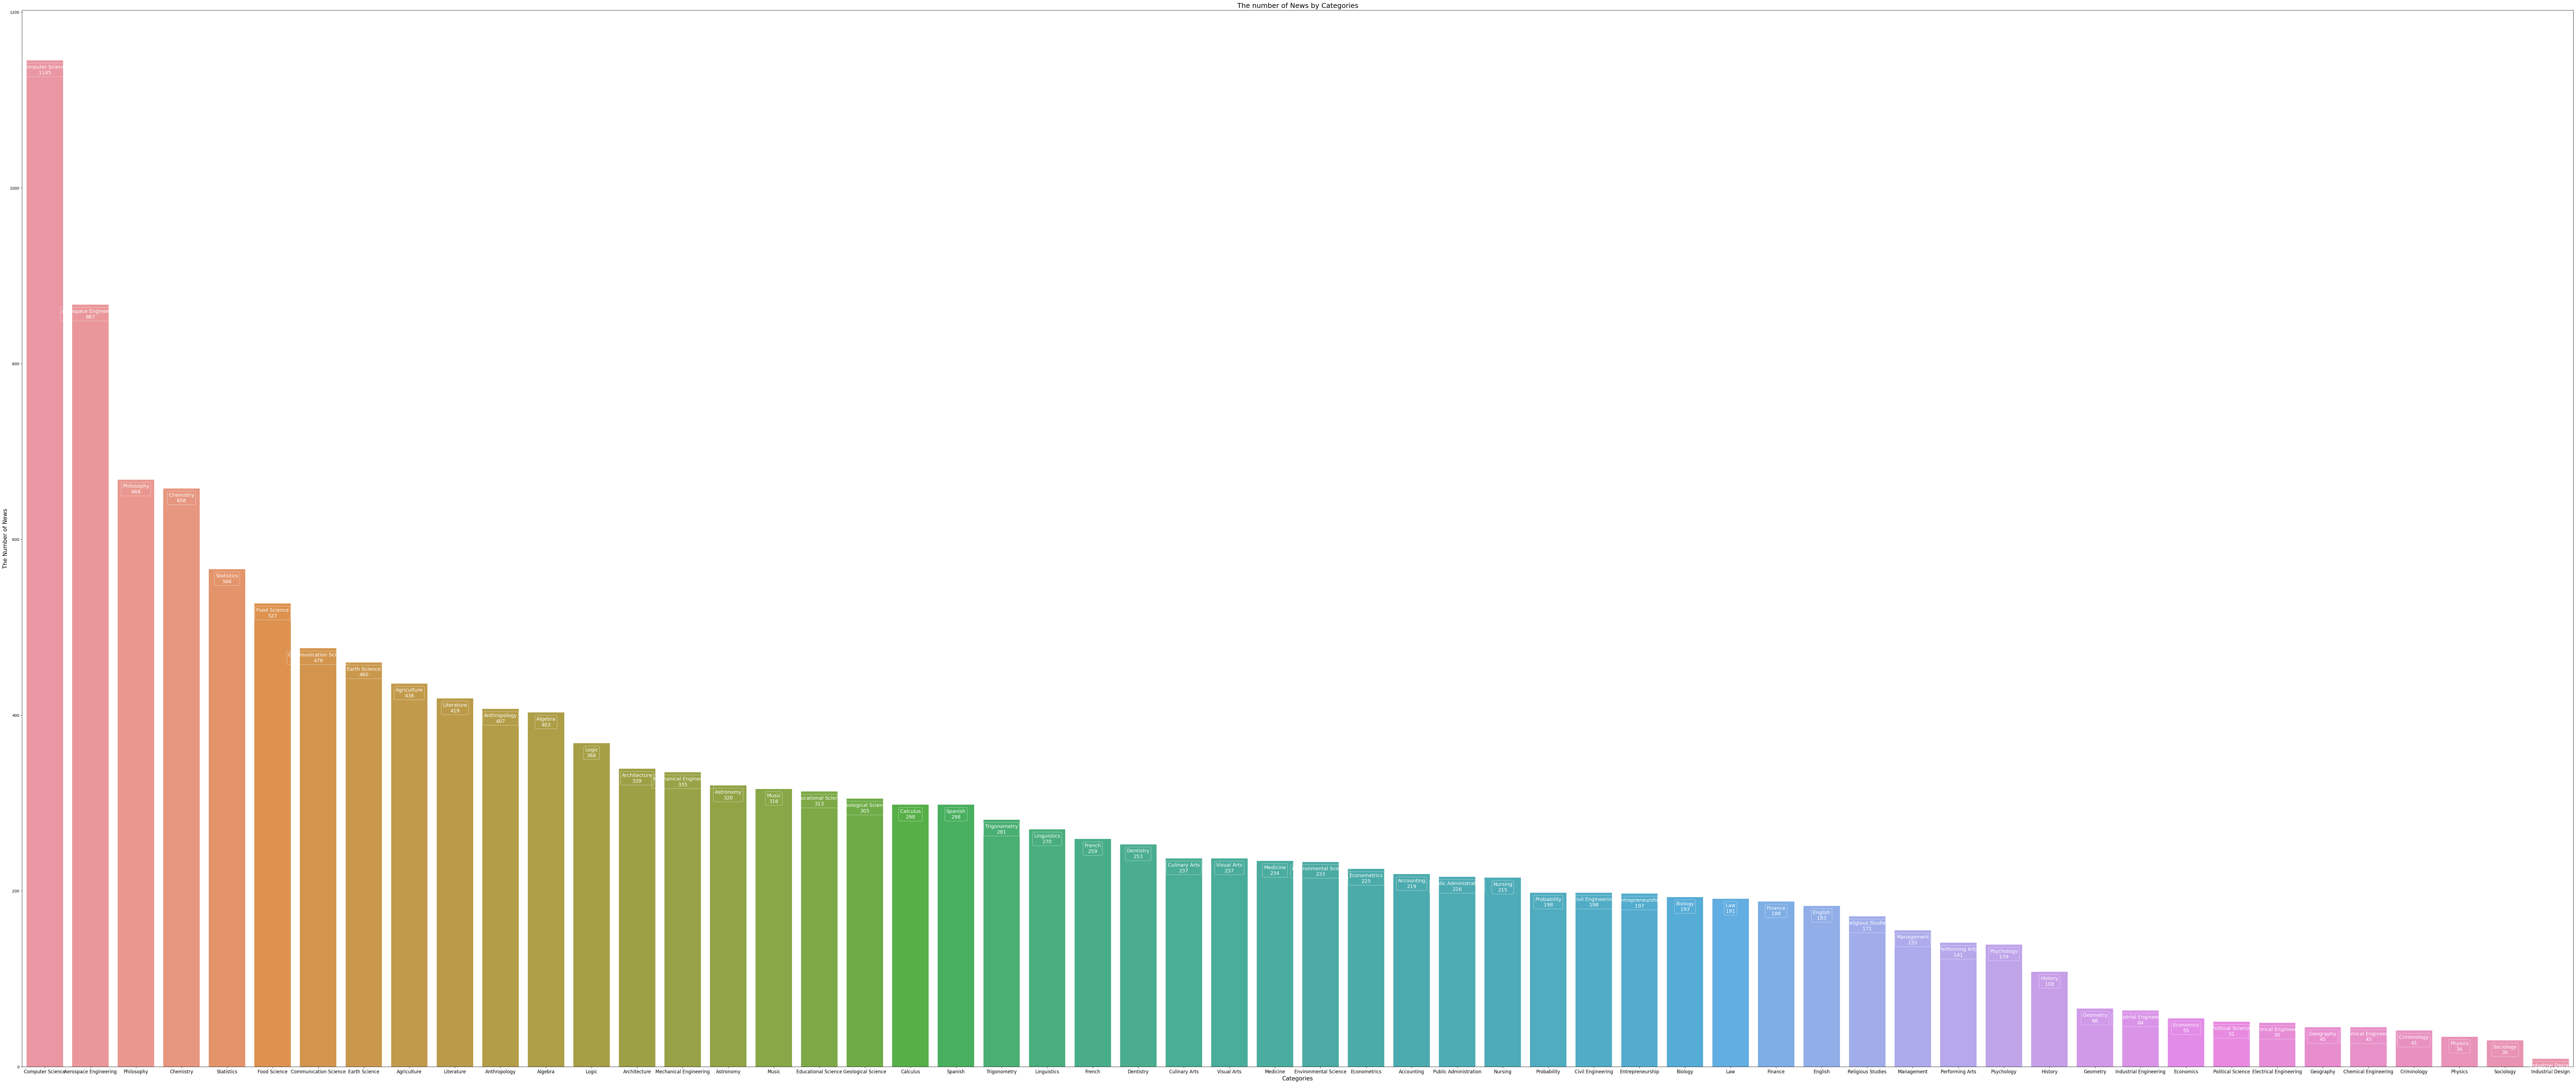

In [14]:
plot_bar_chart(metadata_df, 'file_count', small_first = False)

In [20]:
metadata_df = metadata_df.sort_values('file_count', ascending=False)
metadata_df[:20]

,Category,file_count,max_word_count,min_word_count,avg_word_count,files_below_10_words,files_below_512_words,files_above_1000_words,files_above_3000_words
13,Computer Science,1145,1001,23,301,0,1135,1,0
8,Aerospace Engineering,867,1159,19,306,0,856,1,0
21,Public Administration,668,1017,11,300,0,650,1,0
47,Nursing,658,2362,8,343,1,635,5,0
45,Probability,566,669,1,331,1,561,0,0
49,Civil Engineering,527,9333,12,355,0,512,3,2
43,Entrepreneurship,476,1034,33,310,0,467,1,0
30,Biology,460,3792,16,304,0,453,3,1
5,Law,436,706,18,293,0,430,0,0
11,Finance,419,760,28,309,0,418,0,0
